## Описание проекта

Клиентам «Мегалайн» — федерального оператора сотовой связи предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.

Нужен предварительный анализ тарифов на небольшой выборке клиентов. В распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 
Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов:
Тариф «Смарт»
- Ежемесячная плата: 550 рублей
- Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 3 рубля
    - сообщение: 3 рубля
    - 1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»
- Ежемесячная плата: 1950 рублей
- Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
- Стоимость услуг сверх тарифного пакета:
    - минута разговора: 1 рубль
    - сообщение: 1 рубль
    - 1 Гб интернет-трафика: 150 рублей

## Описание данных
Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

In [1]:
# Подключаем все нужные нам библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
#считаем данные и плсмотрим на их содержание
calls = pd.read_csv ('/datasets/calls.csv')
calls.info()
print(calls.head())

inet = pd.read_csv ('/datasets/internet.csv') 
inet.info()
print(inet.head())

sms = pd.read_csv ('/datasets/messages.csv') 
sms.info()
print(sms.head())

tariffs = pd.read_csv ('/datasets/tariffs.csv') 
tariffs.info()
print(tariffs.head())

users = pd.read_csv ('/datasets/users.csv') 
users.info()
print(users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   s

In [3]:
#Переведем даты в формат дат
calls['call_date'] = pd.to_datetime(calls['call_date'],format='%Y-%m-%d')
inet['session_date'] = pd.to_datetime(inet['session_date'],format='%Y-%m-%d')
sms['message_date'] = pd.to_datetime(sms['message_date'],format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'],format='%Y-%m-%d')

In [4]:
#Округлим минуты в бОльшую сторону, тк даже 1 сек разговора считается минутой
calls['duration'] = np.ceil(calls['duration'])

In [5]:
#Данные кажутся полными и не вызывают вопросов на этом этапе
display(users.describe())
users['user_id'].nunique()
users['city'].unique()
users['tariff'].unique()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


array(['ultra', 'smart'], dtype=object)

In [6]:
print(tariffs.describe())

       messages_included  mb_per_month_included  minutes_included  \
count           2.000000               2.000000          2.000000   
mean          525.000000           23040.000000       1750.000000   
std           671.751442           10861.160159       1767.766953   
min            50.000000           15360.000000        500.000000   
25%           287.500000           19200.000000       1125.000000   
50%           525.000000           23040.000000       1750.000000   
75%           762.500000           26880.000000       2375.000000   
max          1000.000000           30720.000000       3000.000000   

       rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute  
count         2.000000    2.000000         2.000000        2.000000  
mean       1250.000000  175.000000         2.000000        2.000000  
std         989.949494   35.355339         1.414214        1.414214  
min         550.000000  150.000000         1.000000        1.000000  
25%         900.000000  162.

In [7]:
#Не все пользователи отправляли смс
print(sms.describe())
sms['user_id'].nunique()

             user_id
count  123036.000000
mean     1256.989410
std       143.523967
min      1000.000000
25%      1134.000000
50%      1271.000000
75%      1381.000000
max      1499.000000


426

In [8]:
#Почти все пользователи использовали интернет
inet = inet.drop('Unnamed: 0',axis= 1)
print(inet.describe())
inet['user_id'].nunique()

             mb_used        user_id
count  149396.000000  149396.000000
mean      370.192426    1252.099842
std       278.300951     144.050823
min         0.000000    1000.000000
25%       138.187500    1130.000000
50%       348.015000    1251.000000
75%       559.552500    1380.000000
max      1724.830000    1499.000000


497

In [9]:
#Почти все пользователи совершали звонки
print(calls.describe())
calls['user_id'].nunique()

            duration        user_id
count  202607.000000  202607.000000
mean        7.158198    1253.940619
std         5.959173     144.722751
min         0.000000    1000.000000
25%         2.000000    1126.000000
50%         6.000000    1260.000000
75%        11.000000    1379.000000
max        38.000000    1499.000000


492

## Расчеты и добавление результатов в таблицу

Задача - вычислить для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Используем единый подход для расчета экстра-дохода тарифов для каждого пользователя помесячно:
- В исходных данных создадим столбец с месяцем события (звонок/ интернет/ смс)
- Свернем данные в сводную таблицу, вычислив для каждого пользователя помесячно общую продолжительность звонков, количества смс и объемов интернет-трафика
- По id пользователя присоединим название тарифа
- По названию тарифа присоединим лимит по звонкам/ сообщениям и интернету
- Создадим отдельную таблицу для подсчета дохода.
- В цикле вычтем из потраченных минут, смс и трафика доступный лимит. Если лимит не превышен, обнулим значения - они не несут доход.
- Умножим вычисленные экстра-минуты, интернет-трафик и смс на их стоимость.

In [10]:
dt = users.copy()
dt = dt.rename(columns={'tariff': 'tariff_name'})

In [11]:
calls['month'] = calls['call_date'].dt.month
calls_users_by_month = calls.pivot_table(index = ['user_id', 'month'], values='duration',aggfunc= ['sum'])

sms['month'] = sms['message_date'].dt.month
sms_users_by_month = sms.pivot_table(index=['user_id', 'month'], values='id',aggfunc= ['count'])

inet['month'] = inet['session_date'].dt.month
inet_users_by_month = inet.pivot_table(index=['user_id', 'month'], values='mb_used',aggfunc=['sum'])

services = calls_users_by_month.copy()
services = services.merge(sms_users_by_month, on = ['user_id', 'month'], how = 'outer')
services = services.merge(inet_users_by_month, on = ['user_id', 'month'], how = 'outer')
print(services.shape)

(3214, 3)


In [12]:
df = users.copy()
df = df.rename(columns={'tariff': 'tariff_name'})
df = df.merge(tariffs, on='tariff_name', how = 'left')
df = df.merge(services, on='user_id', how = 'right')

df = df.rename(columns={('sum', 'duration') : 'calls'})
df = df.rename(columns={('count', 'id') : 'sms'})
df = df.rename(columns={('sum', 'mb_used') : 'inet'})
print(df.shape)

(3214, 18)


/opt/conda/lib/python3.9/site-packages/pandas/core/reshape/merge.py:648: UserWarning: merging between different levels can give an unintended result (1 levels on the left,2 on the right)
  warnings.warn(msg, UserWarning)


In [13]:
df['revenue'] = df['rub_monthly_fee']


def revenue(df):
    if df['calls']>df['minutes_included']:
        df['revenue'] += (df['calls']-df['minutes_included'])*df['rub_per_minute']
    if df['inet']>df['mb_per_month_included']:
        df['revenue'] += np.ceil((df['inet']-df['mb_per_month_included'])/1024)*df['rub_per_gb']
    if df['sms']>df['messages_included']:
        df['revenue'] += (df['sms']-df['messages_included'])*df['rub_per_message']
    return df['revenue']


df['revenue'] = df.apply(revenue, axis=1)
display(df.tail(10))

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,calls,sms,inet,revenue
3204,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,NaN,19.0,17289.85,1950.0
3205,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,NaN,20.0,13688.65,1950.0
3206,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,NaN,14.0,21673.80,1950.0
3207,1473,18,NaN,Красноярск,Николай,Лебедев,2018-08-05,ultra,1000,30720,3000,1950,150,1,1,NaN,20.0,18418.26,1950.0
3208,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,NaN,17.0,11050.56,550.0
3209,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,NaN,32.0,17206.30,950.0
3210,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,NaN,21.0,19559.44,1550.0
3211,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,NaN,20.0,17491.56,1150.0
3212,1489,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,50,15360,500,550,200,3,3,NaN,35.0,17322.51,950.0
3213,1476,50,NaN,Москва,Валентина,Семенова,2018-04-30,ultra,1000,30720,3000,1950,150,1,1,NaN,NaN,530.78,1950.0


In [14]:
df['revenue']

0       1950.0
1       1950.0
2       1950.0
3       1950.0
4       1950.0
         ...  
3209     950.0
3210    1550.0
3211    1150.0
3212     950.0
3213    1950.0
Name: revenue, Length: 3214, dtype: float64

## Анализ данных

Задача - Описать поведение клиентов оператора, исходя из выборки. 
Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.


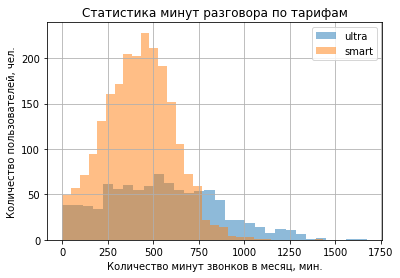

In [15]:
ax = df.loc[df['tariff_name'] == 'ultra']['calls'].hist(bins = 30, alpha = 0.5, label = 'ultra')
ax = df.loc[df['tariff_name'] == 'smart']['calls'].hist(bins = 30, alpha = 0.5, label = 'smart')
ax.set_xlabel('Количество минут звонков в месяц, мин.')
ax.set_ylabel('Количество пользователей, чел.')
plt.title('Статистика минут разговора по тарифам')
ax.legend();

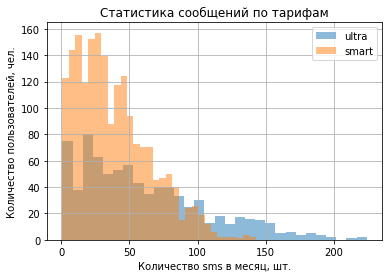

In [16]:
ax = df.loc[df['tariff_name'] == 'ultra']['sms'].hist(bins = 30, alpha = 0.5, label = 'ultra')
ax = df.loc[df['tariff_name'] == 'smart']['sms'].hist(bins = 30, alpha = 0.5, label = 'smart')
ax.set_xlabel('Количество sms в месяц, шт.')
ax.set_ylabel('Количество пользователей, чел.')
plt.title('Статистика сообщений по тарифам')
ax.legend();

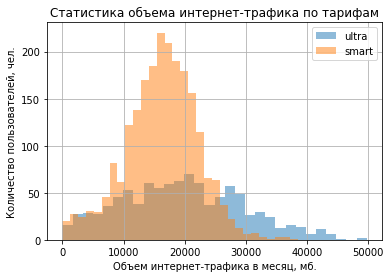

In [17]:
ax = df.loc[df['tariff_name'] == 'ultra']['inet'].hist(bins = 30, alpha = 0.5, label = 'ultra')
ax = df.loc[df['tariff_name'] == 'smart']['inet'].hist(bins = 30, alpha = 0.5, label = 'smart')
ax.set_xlabel('Объем интернет-трафика в месяц, мб.')
ax.set_ylabel('Количество пользователей, чел.')
plt.title('Статистика объема интернет-трафика по тарифам')
ax.legend();

Smart statistics:


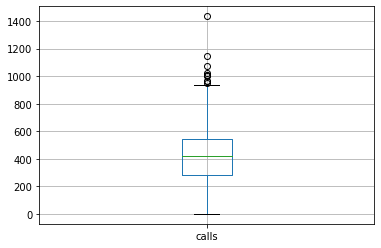

count    2223.000000
mean      419.062978
std       189.325618
min         0.000000
25%       285.000000
50%       423.000000
75%       545.500000
max      1435.000000
Name: calls, dtype: float64

Ultra statistics:


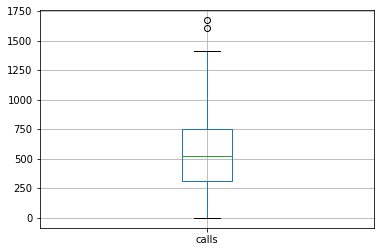

count     951.000000
mean      545.451104
std       306.925754
min         0.000000
25%       310.000000
50%       528.000000
75%       756.500000
max      1673.000000
Name: calls, dtype: float64

Дисперсия звонков тарифа Smart:  35828.06530953033
Дисперсия звонков тарифа Ultra:  94104.36117385984
Стандартное отклонение звонков тарифа Smart:  189.2830296395594
Стандартное отклонение звонков тарифа Ultra:  306.76434143143143
Ср. количество минут разговора в месяц на тарифе Smart:  419.0629779577148
Ср. количество минут разговора в месяц на тарифе Ultra:  545.4511041009464


In [18]:
print('Smart statistics:')
df.loc[df['tariff_name'] == 'smart'].boxplot(column='calls') 
plt.show()
display(df.loc[df['tariff_name'] == 'smart']['calls'].describe())

print('Ultra statistics:')
df.loc[df['tariff_name'] == 'ultra'].boxplot(column='calls') 
plt.show()
display(df.loc[df['tariff_name'] == 'ultra']['calls'].describe())


print('Дисперсия звонков тарифа Smart: ',np.var(df.loc[df['tariff_name'] == 'smart']['calls']))
print('Дисперсия звонков тарифа Ultra: ',np.var(df.loc[df['tariff_name'] == 'ultra']['calls']))

print('Стандартное отклонение звонков тарифа Smart: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'smart']['calls'])))
print('Стандартное отклонение звонков тарифа Ultra: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'ultra']['calls'])))

print('Ср. количество минут разговора в месяц на тарифе Smart: ',np.mean(df.loc[df['tariff_name'] == 'smart']['calls']))
print('Ср. количество минут разговора в месяц на тарифе Ultra: ',np.mean(df.loc[df['tariff_name'] == 'ultra']['calls']))

Smart statistics:


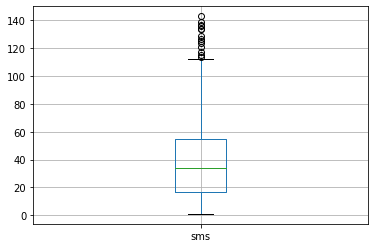

count    1922.000000
mean       38.716441
std        26.787949
min         1.000000
25%        17.000000
50%        34.000000
75%        55.000000
max       143.000000
Name: sms, dtype: float64

Ultra statistics:


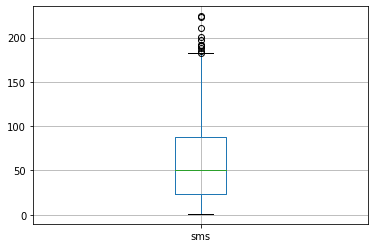

count    795.000000
mean      61.161006
std       45.931026
min        1.000000
25%       24.000000
50%       51.000000
75%       87.500000
max      224.000000
Name: sms, dtype: float64

Дисперсия sms тарифа Smart:  717.220843110227
Дисперсия sms тарифа Ultra:  2107.0055235156838
Стандартное отклонение sms тарифа Smart:  26.780979129042816
Стандартное отклонение sms тарифа Ultra:  45.90212983637779
Ср. количество sms в месяц на тарифе Smart:  38.71644120707596
Ср. количество sms в месяц на тарифе Ultra:  61.161006289308176


In [19]:
print('Smart statistics:')
df.loc[df['tariff_name'] == 'smart'].boxplot(column='sms') 
plt.show()
display(df.loc[df['tariff_name'] == 'smart']['sms'].describe())

print('Ultra statistics:')
df.loc[df['tariff_name'] == 'ultra'].boxplot(column='sms') 
plt.show()
display(df.loc[df['tariff_name'] == 'ultra']['sms'].describe())

print('Дисперсия sms тарифа Smart: ',np.var(df.loc[df['tariff_name'] == 'smart']['sms']))
print('Дисперсия sms тарифа Ultra: ',np.var(df.loc[df['tariff_name'] == 'ultra']['sms']))

print('Стандартное отклонение sms тарифа Smart: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'smart']['sms'])))
print('Стандартное отклонение sms тарифа Ultra: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'ultra']['sms'])))

print('Ср. количество sms в месяц на тарифе Smart: ',np.mean(df.loc[df['tariff_name'] == 'smart']['sms']))
print('Ср. количество sms в месяц на тарифе Ultra: ',np.mean(df.loc[df['tariff_name'] == 'ultra']['sms']))

Smart statistics:


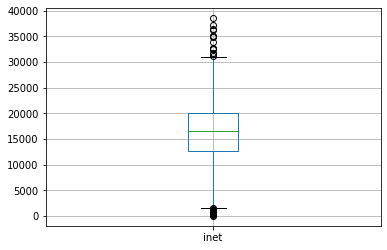

count     2228.000000
mean     16215.661849
std       5861.736234
min          0.000000
25%      12649.272500
50%      16507.740000
75%      20043.792500
max      38552.450000
Name: inet, dtype: float64

Ultra statistics:


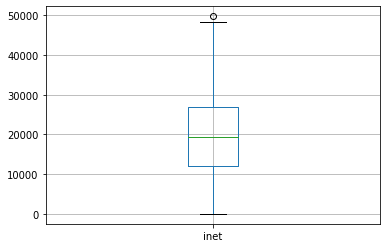

count      975.000000
mean     19668.485262
std       9943.050284
min          0.000000
25%      12008.305000
50%      19394.290000
75%      26896.550000
max      49745.690000
Name: inet, dtype: float64

Дисперсия объема интернет-трафика тарифа Smart:  34344529.80091768
Дисперсия объема интернет-трафика тарифа Ultra:  98762849.72293654
Стандартное отклонение объема интернет-трафика тарифа Smart:  5860.420616382213
Стандартное отклонение объема интернет-трафика тарифа Ultra:  9937.949975872114
Ср. объем интернет-трафика в месяц на тарифе Smart:  15.835607274601662
Ср. объем интернет-трафика в месяц на тарифе Ultra:  19.20750513822115


In [20]:
print('Smart statistics:')
df.loc[df['tariff_name'] == 'smart'].boxplot(column='inet') 
plt.show()
display(df.loc[df['tariff_name'] == 'smart']['inet'].describe())

print('Ultra statistics:')
df.loc[df['tariff_name'] == 'ultra'].boxplot(column='inet') 
plt.show()
display(df.loc[df['tariff_name'] == 'ultra']['inet'].describe())

print('Дисперсия объема интернет-трафика тарифа Smart: ',np.var(df.loc[df['tariff_name'] == 'smart']['inet']))
print('Дисперсия объема интернет-трафика тарифа Ultra: ',np.var(df.loc[df['tariff_name'] == 'ultra']['inet']))

print('Стандартное отклонение объема интернет-трафика тарифа Smart: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'smart']['inet'])))
print('Стандартное отклонение объема интернет-трафика тарифа Ultra: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'ultra']['inet'])))

print('Ср. объем интернет-трафика в месяц на тарифе Smart: ',np.mean(df.loc[df['tariff_name'] == 'smart']['inet'])/1024)
print('Ср. объем интернет-трафика в месяц на тарифе Ultra: ',np.mean(df.loc[df['tariff_name'] == 'ultra']['inet'])/1024)

### Выводы:
- Распределение потребления услуг смарт-клиентами похоже на пуассоновское, чего нельзя сказать о клиентах тарифа ультра
- Средние значения потребления по тарифу смарт и ультра:
    - Интернет-трафик: 16 гб vs 19 гб (+19%)
    - Количество сообщений: 39 vs 61 (+56%)
    - Количество минут разговора: 419 vs 545 (+30%)
- Аналогично, медианные значения по тарифу смарт и ультра:
    - Интернет-трафик: 16 гб vs 19 гб (+19%)
    - Количество сообщений: 34 vs 51 (+50%)
    - Количество минут разговора: 423 vs 528 (+25%)
- В целом пользователей ультра-тарифа характеризует втрое бОльшая дисперсия по всем видам услуг по сравнению с аналогичным разбросом на смарт-тарифе. Соответственно, стандартные отклонения также больше на тарифе ультра в 1,6-1,7 раза.

## Проверка гипотез

### Гипотеза 1:
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Нулевая гипотеза: средняя выручка пользователей тарифа «Ультра» не равна средней выручке пользователей тарифа «Смарт»

Альтернативная гипотеза: средняя выручка пользователей тарифа «Ультра» равна средней выручки пользователей тарифа «Смарт»

In [21]:
display(df.pivot_table(index = 'tariff_name',values = 'revenue',aggfunc = 'mean')) #спойлер

,revenue
tariff_name,
smart,1289.973531
ultra,2070.152284


In [22]:
# Проверим гипотезу двусторонним тестом 
#(нам неважно, больше или меньше значения средних доходностей в разрезе тарифов, поэтому тест двусторонний)

alpha = .05 # критический уровень статистической значимости
interested_value = df.loc[df['tariff_name'] == 'smart']['revenue'].mean() #среднее значение дохода пользователей тарифа Смарт
revenue_ultra = df.loc[df['tariff_name']=='ultra']['revenue'] #срез доходов по другому тарифу

results = st.ttest_1samp(
    revenue_ultra, 
    interested_value)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")


p-значение: 0.0
Отвергаем нулевую гипотезу


### Гипотеза 2:
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Нулевая гипотеза: cредняя выручка пользователей из Москвы равна выручке пользователей из других регионов

Альтернативная гипотеза: cредняя выручка пользователей из Москвы НЕ равна выручке пользователей из других регионов

In [23]:
# Проверим гипотезу двусторонним тестом 
#(нам неважно, больше или меньше значения средних доходностей в разрезе регионов, поэтому тест двусторонний)

alpha = .05 # критический уровень статистической значимости
interested_value = df.loc[df['city']=='Москва']['revenue'].mean() #Среднее значение дохода пользователей Москвы
revenue_regions = df.loc[df['city']!='Москва']['revenue'] #срез доходов по другим регионам

results = st.ttest_1samp(
    revenue_regions, 
    interested_value)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1696376636320093
Не получилось отвергнуть нулевую гипотезу


### Выводы: 
- средняя выручка пользователей тарифа «Ультра» не равна средней выручке пользователей тарифа «Смарт»
- cредняя выручка пользователей из Москвы равна выручке пользователей из других регионов

 ## Дополнительный анализ по выручке
 
 Проведем небольшой анализ выручки от клиентов в разрезе тарифов

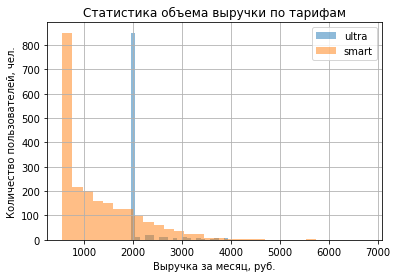

In [24]:
ax = df.loc[df['tariff_name'] == 'ultra']['revenue'].hist(bins = 30, alpha = 0.5, label = 'ultra')
ax = df.loc[df['tariff_name'] == 'smart']['revenue'].hist(bins = 30, alpha = 0.5, label = 'smart')
ax.set_xlabel('Выручка за месяц, руб.')
ax.set_ylabel('Количество пользователей, чел.')
plt.title('Статистика объема выручки по тарифам')
ax.legend();

Smart statistics:


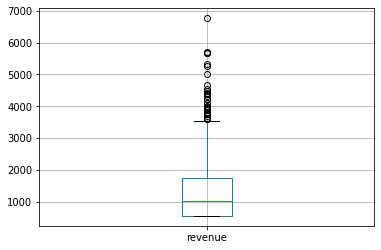

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: revenue, dtype: float64

Ultra statistics:


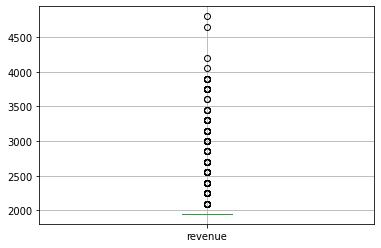

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: revenue, dtype: float64

Дисперсия выручки тарифа Smart:  669485.2209234245
Дисперсия выручки тарифа Ultra:  141373.07325620347
Стандартное отклонение выручки тарифа Smart:  818.2207653949051
Стандартное отклонение выручки тарифа Ultra:  375.9961080333192
Ср. выручка в месяц на тарифе Smart:  1289.9735307312696
Ср. выручка в месяц на тарифе Ultra:  2070.1522842639592


In [25]:
print('Smart statistics:')
df.loc[df['tariff_name'] == 'smart'].boxplot(column='revenue') 
plt.show()
display(df.loc[df['tariff_name'] == 'smart']['revenue'].describe())

print('Ultra statistics:')
df.loc[df['tariff_name'] == 'ultra'].boxplot(column='revenue')
plt.show()
display(df.loc[df['tariff_name'] == 'ultra']['revenue'].describe())

print('Дисперсия выручки тарифа Smart: ',np.var(df.loc[df['tariff_name'] == 'smart']['revenue']))
print('Дисперсия выручки тарифа Ultra: ',np.var(df.loc[df['tariff_name'] == 'ultra']['revenue']))

print('Стандартное отклонение выручки тарифа Smart: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'smart']['revenue'])))
print('Стандартное отклонение выручки тарифа Ultra: ',np.sqrt(np.var(df.loc[df['tariff_name'] == 'ultra']['revenue'])))

print('Ср. выручка в месяц на тарифе Smart: ',np.mean(df.loc[df['tariff_name'] == 'smart']['revenue']))
print('Ср. выручка в месяц на тарифе Ultra: ',np.mean(df.loc[df['tariff_name'] == 'ultra']['revenue']))

### Выводы
- Большинство пользователей тарифа ultra вписываются в лимиты и платят только ежемесячную комиссию
- Средний доход от ultra-клиента составляет 2070 руб, от smart-клиента - 1289 руб - на 61% меньше
- Разброс значений выручки smart клиента больше, чем у ultra: стандартное отклонение вдвое больше


 ## Общий вывод

- На основании данной выборки можно утверждать, что тариф ultra более выгоден, чем тариф smart.
- При этом в разрезе регионов нет различий по доходности.
- Пользователи ultra-тарифа, в среднем, платят 2070 руб, что в 1,6 раза больше smart-тарифа. 
- Большинство пользователей тарифа ultra вписываются в лимиты и платят только ежемесячную комиссию, что облегчает планирование объема доходов от сегмента.
- С точки зрения потребления - пользователей ultra-тарифа характеризует втрое бОльший разброс значений по всем видам услуг.
- Средние значения потребления по тарифу ultra в 1,2-1,6 раз больше smart:
    - Интернет-трафик: 16 гб vs 19 гб (+19%)
    - Количество сообщений: 39 vs 61 (+56%)
    - Количество минут разговора: 419 vs 545 (+30%)